#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 05
**CH05A What Likelihood of Loss to Expect on a Stock Portfolio?**

using the sp500 dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/sp500/clean/"
data_out = dirname + "da_case_studies/ch05-stock-market-loss-generalize/"
output = dirname + "da_case_studies/ch05-stock-market-loss-generalize/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
sp500 = pd.read_csv("/workspaces/codespaces-jupyter/data/SP500_2006_16_data.csv")
sp500# sp500 = pd.read_csv("https://osf.io/h64z2/download")

,DATE,VALUE
0,2006-08-25,1295.09
1,2006-08-28,1301.78
2,2006-08-29,1304.28
3,2006-08-30,1304.27
4,2006-08-31,1303.82
...,...,...
2606,2016-08-22,2182.64
2607,2016-08-23,2186.90
2608,2016-08-24,2175.44
2609,2016-08-25,2172.47


In [4]:
sp500 = sp500.replace("", np.nan).replace("#N/A", np.nan).dropna().reset_index(drop=True)

Create percent return

In [5]:
#Fractional change between the current and a prior element. Examples below
sp500["pct_return"] = sp500["VALUE"].pct_change() * 100

In [6]:
#Fractial change in action
s = pd.Series([90, 91, None, 85])
s.ffill().pct_change()

0         NaN
1    0.011111
2    0.000000
3   -0.065934
dtype: float64

Create date variables (we dont use these though)

In [7]:
sp500["DATE"] = pd.to_datetime(sp500["DATE"], format="%Y-%m-%d")
sp500["year"] = sp500["DATE"].dt.year
sp500["month"] = sp500["DATE"].dt.month
sp500["yearmonth"] = sp500["year"] * 100 + sp500["month"]

### Figure 5.1 Histogram of daily returns in the entire data

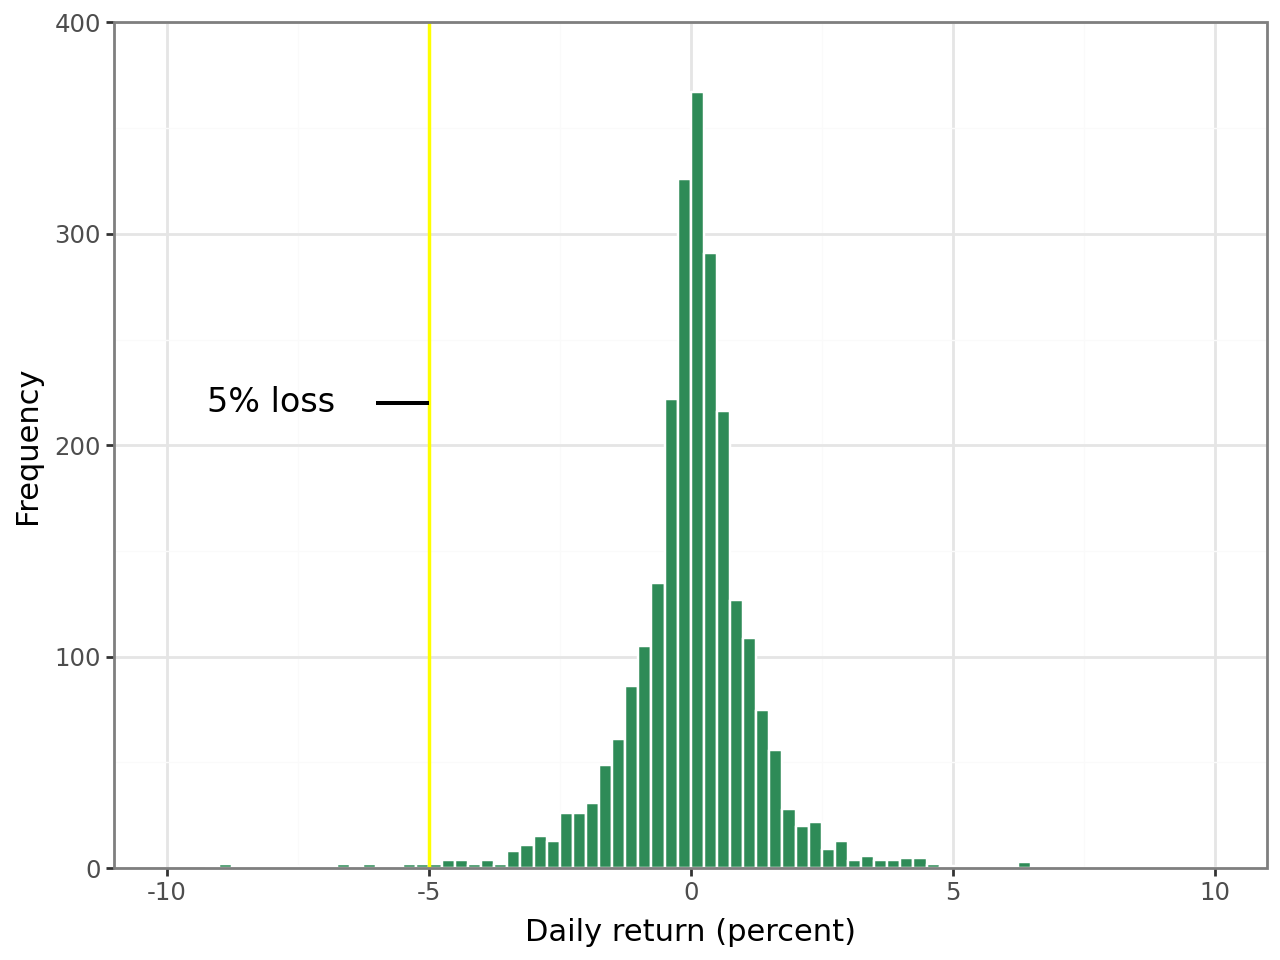

In [8]:
(
    ggplot(sp500, aes("pct_return"))
    + geom_histogram(
        binwidth=0.25, color="white", fill="seagreen", boundary=0, closed="left"
    )
    + geom_vline(xintercept=-5, size=0.7, color="yellow")
    + labs(x="Daily return (percent)", y="Frequency")
    + coord_cartesian(xlim=[-10, 10], ylim=[0, 400])
    + scale_y_continuous(expand=[0, 0])
    + geom_segment(aes(x=-6, y=220, xend=-5, yend=220))
    + annotate("text", x=-8, y=220, label="5% loss", size=12)
    + theme_bw()
)


In [9]:
sp500["pct_return"].describe()

count    2518.000000
mean        0.029145
std         1.315438
min        -9.034980
25%        -0.453734
50%         0.070897
75%         0.582782
max        11.580036
Name: pct_return, dtype: float64

In [10]:
sp500max=sp500.loc[sp500["pct_return"].idxmax()]
sp500max

DATE          2008-10-13 00:00:00
VALUE                     1003.35
pct_return              11.580036
year                         2008
month                          10
yearmonth                  200810
Name: 536, dtype: object

In [11]:
sp500.count()
sp500
sp500less5 = sp500.loc[sp500["pct_return"] < -5].reset_index(drop=True)
sp500less5["pct_return_decimal"] = sp500less5["pct_return"] / 100
sp500less5

,DATE,VALUE,pct_return,year,month,yearmonth,pct_return_decimal
0,2008-09-29,1106.39,-8.789705,2008,9,200809,-0.087897
1,2008-10-07,996.23,-5.739481,2008,10,200810,-0.057395
2,2008-10-09,909.92,-7.616708,2008,10,200810,-0.076167
3,2008-10-15,907.84,-9.034980,2008,10,200810,-0.090350
4,2008-10-22,896.78,-6.101251,2008,10,200810,-0.061013
5,2008-11-05,952.77,-5.267711,2008,11,200811,-0.052677
6,2008-11-06,904.88,-5.026397,2008,11,200811,-0.050264
7,2008-11-12,852.30,-5.189388,2008,11,200811,-0.051894
8,2008-11-19,806.58,-6.115560,2008,11,200811,-0.061156
9,2008-11-20,752.44,-6.712291,2008,11,200811,-0.067123


In [12]:
sp500less5['DATE'].min(), sp500less5['DATE'].max()

(Timestamp('2008-09-29 00:00:00'), Timestamp('2011-08-08 00:00:00'))

In [13]:
sp500less5["pct_return"].mean()

np.float64(-6.65138836502497)

In [14]:
true_share = (sp500["pct_return"] <= -5).mean()
print(true_share)

0.005160778086542279


### Figure 5.2 prep

 Create 10 000 samples, with 500 and 1000 observations in each sample, taken from sp500["pct_return"]

In every sample: for each observation, check if it is a loss of 5% or more. Then calculate the percentage of observations out of 500 or 1000 where the loss exceeds 5%. 

In [15]:
from importlib import import_module

# Try to import create_sample_frame from the func directory
create_sample = import_module("func_sample")  # replace with actual filename without .py
create_sample_frame = create_sample.create_sample_frame

help(create_sample_frame)

ModuleNotFoundError: No module named 'func_sample'

In [16]:
n_samples = 10000  # Define the number of samples

# For n=1000
samples_1000 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 1000), replace=True)
a=samples_1000 < -5

nobs_1000 = np.mean(samples_1000 < -5, axis=1)

# For n=500
samples_500 = np.random.choice(sp500["pct_return"].dropna(), size=(n_samples, 500), replace=True)
nobs_500 = np.mean(samples_500 < -5, axis=1)


In [17]:
a = pd.DataFrame(a)
a

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
nobs_df = pd.DataFrame({"nobs_500": nobs_500, "nobs_1000": nobs_1000})*100

In [19]:
a = pd.DataFrame(samples_1000).T
a

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.396539,0.809531,-0.115288,-0.325796,-0.119862,-0.654496,-0.643531,-0.896605,-1.455893,1.400750,...,-0.019080,1.336402,-0.948677,-0.539549,0.633913,1.518419,-0.285911,2.251997,0.964311,-1.897114
1,-0.039005,1.187385,0.323556,-0.338044,-0.413112,0.330405,-0.999773,-0.971183,4.768487,0.630279,...,0.967271,-1.592693,-1.257619,1.648044,1.788835,-0.604931,-0.075264,-0.729931,0.598189,1.204924
2,-0.136524,-2.110011,0.901272,1.312966,-1.620539,-1.432772,0.104265,0.367236,10.789002,-0.827362,...,-1.864846,0.792412,0.242651,-0.429493,0.030958,-0.246425,0.006092,-1.075015,0.184372,0.511410
3,-0.246425,0.644236,-0.671615,-1.415388,-0.879573,2.269134,1.336402,1.026495,-1.028193,3.805323,...,0.734577,-3.176432,-0.604931,-1.173278,2.456653,-0.345670,-0.150112,0.822003,1.357476,-3.851787
4,-0.881016,-0.177797,-5.267711,0.548819,-0.338044,-0.034361,-1.297917,-1.661618,0.940534,2.183048,...,0.085326,-0.031423,0.720392,-1.046280,-3.441147,1.153139,-1.050182,1.183993,-0.567604,0.181199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.248509,-0.070109,1.173138,-0.298546,1.046818,0.071994,0.490021,2.248847,0.148515,-0.147879,...,-0.244368,-0.438850,-0.357000,0.196708,-2.992204,1.336402,0.373705,0.001562,0.667779,-1.664761
996,0.094654,0.042836,-0.269053,-1.145103,0.310138,-1.689438,0.850146,0.764405,0.126723,-1.646792,...,1.068834,0.254842,0.196708,0.556096,0.368634,1.356500,2.178468,-0.175270,-0.488862,1.106209
997,0.940534,-2.501028,0.006092,-0.386175,0.424837,-0.795016,-1.210278,0.211889,0.781000,-0.251470,...,-0.091943,-0.013928,0.428688,0.177394,0.455391,0.381040,-0.297357,0.508752,-0.048897,0.367804
998,0.941270,-2.957641,0.733654,0.053808,0.221774,-0.631840,-0.135805,-0.256408,0.324306,-0.278761,...,-1.512607,2.871875,-0.577501,0.088190,-0.458122,-0.031383,-1.614723,1.254902,0.140533,1.443947


In [20]:
nobs_df

,nobs_500,nobs_1000
0,1.0,0.4
1,0.8,0.7
2,0.2,0.8
3,0.2,0.9
4,0.0,0.4
...,...,...
9995,1.0,0.4
9996,0.2,0.7
9997,0.4,0.5
9998,0.6,0.7


In [21]:
error = (
    norm.ppf(0.975) * np.std(nobs_df["nobs_1000"]) / np.sqrt(len(nobs_df["nobs_1000"]))
)
left = np.mean(nobs_df["nobs_1000"]) - error
right = np.mean(nobs_df["nobs_1000"]) + error


### Figure 5.2

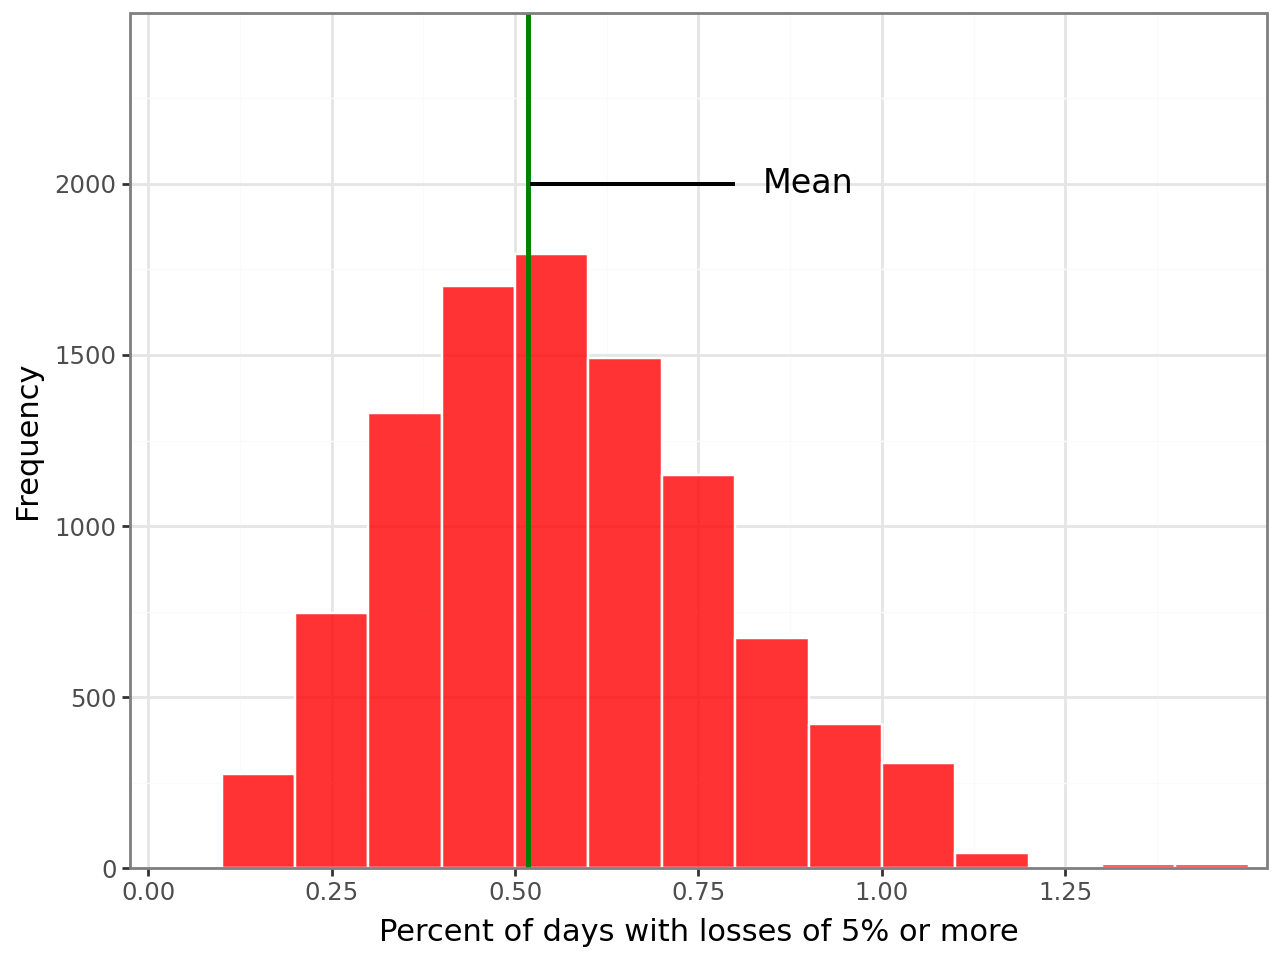

In [22]:
(
    ggplot(nobs_df, aes("nobs_1000"))
    + geom_histogram(
        binwidth=0.1,
        color="white",
        fill="red",
        alpha=0.8,
        center=0.75,
        closed="left",
    )
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + geom_vline(aes(xintercept=nobs_df["nobs_1000"].mean()), color="green", size=1)
    + coord_cartesian(xlim=[0, 1.5], ylim=(0, 2500))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(
        expand=(0.00, 0.00), limits=(0, 2500), breaks=np.arange(0, 2500, 500)
    )
    + geom_segment(aes(x=0.8, y=2000, xend=0.52, yend=2000))
    + annotate("text", x=0.9, y=2000, label="Mean", size=12)
    + theme_bw()
)

In [23]:
nobs_df["nobs_1000"].std()

np.float64(0.22531495419269953)

In [24]:
nobs_df["nobs_500"].std()

np.float64(0.32010518760731344)

In [25]:
nobs_df["nobs_1000"].mean()

np.float64(0.5180899999999999)

In [26]:
nobs_df["nobs_500"].mean()

np.float64(0.51466)

### Figure 5.3 

Not working with epanechnikov kernel

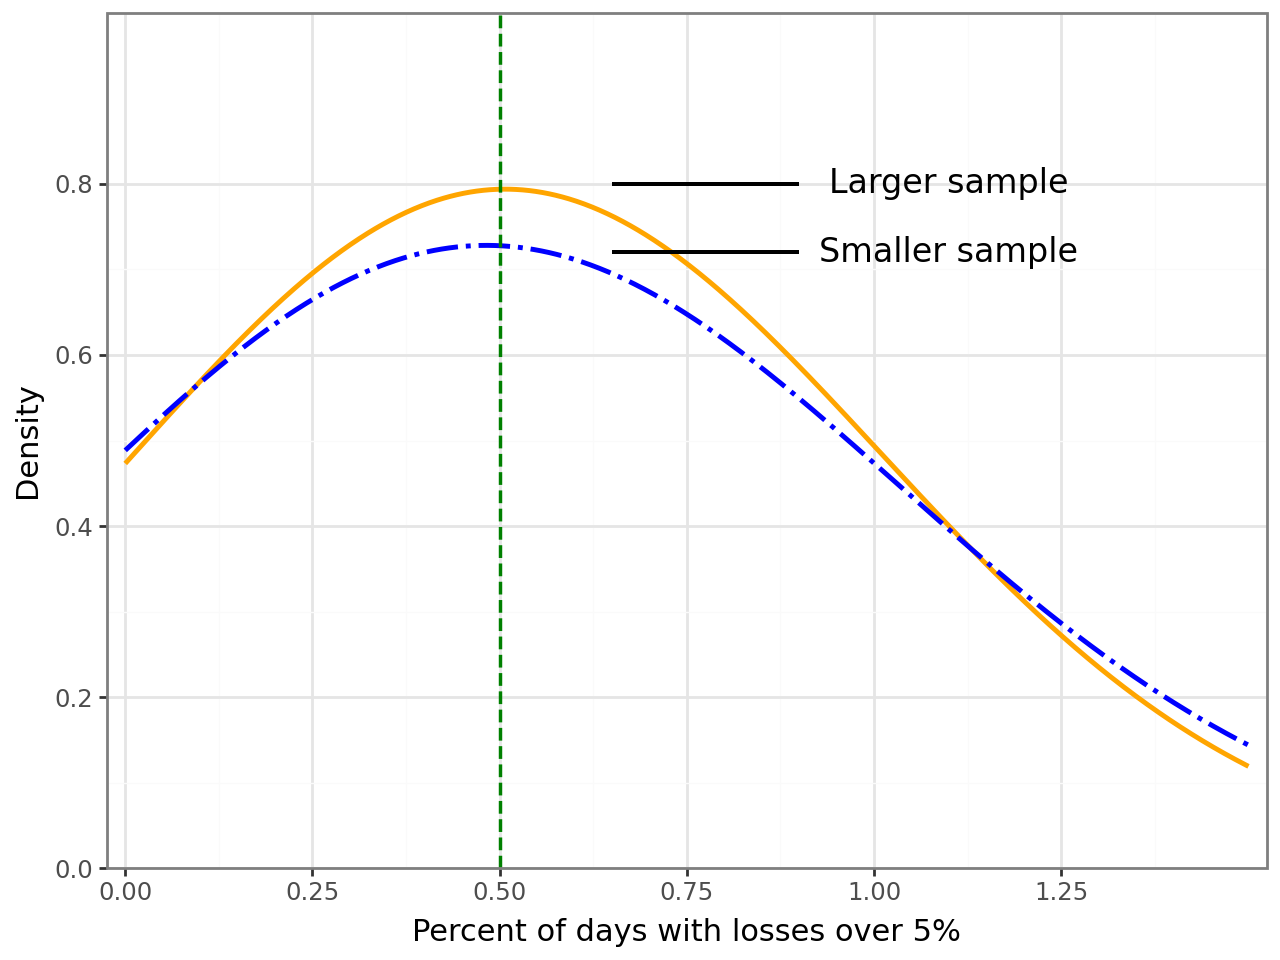

In [27]:
(
    ggplot(nobs_df)
    + stat_density(aes(x="nobs_1000"), color="orange", geom="line", bw=0.45, size=1)
    + stat_density(
        aes("nobs_500"),
        color="blue",
        geom="line",
        bw=0.45,
        linetype="dashdot",
        size=1,
    )
    + labs(x="Percent of days with losses over 5%", y="Density")
    + geom_vline(xintercept=0.5, color="green", size=0.7, linetype="dashed")
    + geom_segment(aes(x=0.9, y=0.8, xend=0.65, yend=0.8), size=0.5)
    + annotate("text", x=1.1, y=0.8, label="Larger sample", size=12)
    + geom_segment(aes(x=0.9, y=0.72, xend=0.65, yend=0.72), size=0.5)
    + annotate("text", x=1.1, y=0.72, label="Smaller sample", size=12)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.5), breaks=np.arange(0, 1.5, 0.25))
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 1), breaks=np.arange(0, 1, 0.2))
    + theme_bw()
    + theme(
        legend_position="none",
    )
)

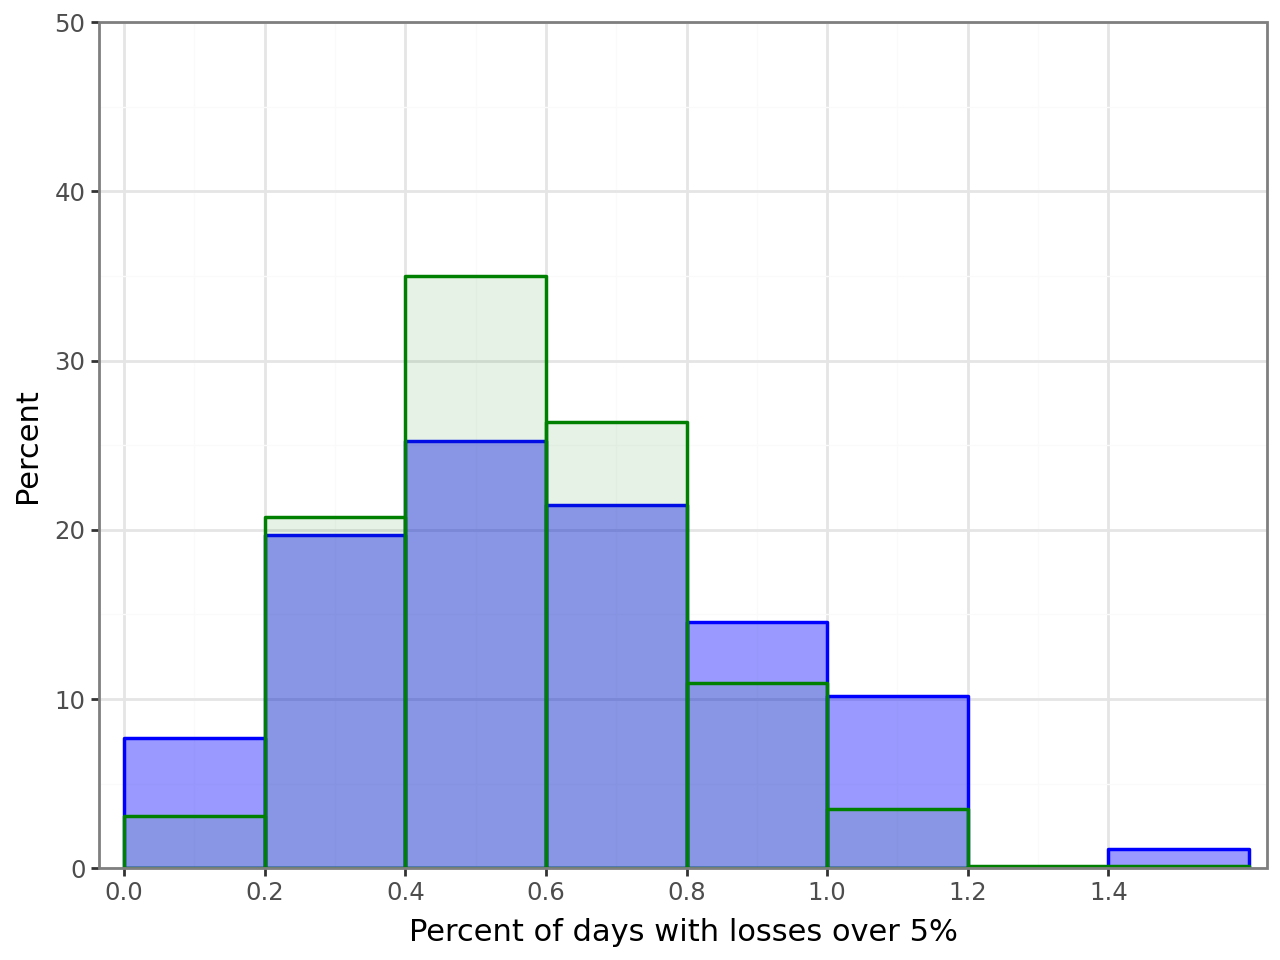

In [28]:
(
    ggplot(nobs_df)
    + geom_histogram(
        aes(x="nobs_500", y="stat(count)/sum(stat(count))*100"),
        color="blue",
        fill="blue",
        binwidth=0.2,
        center=0.5,
        size=0.7,
        alpha=0.4,
        closed="left",
    )
    + geom_histogram(
        aes(x="nobs_1000", y="stat(count)/sum(stat(count))*100"),
        color="green",
        fill="green",
        binwidth=0.2,
        center=0.5,
        alpha=0.1,
        size=0.7,
        closed="left",
    )
    + ylab("Percent")
    + xlab("Percent of days with losses over 5%")
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(-0.01, 1.6), breaks=np.arange(0, 1.6, 0.2)
    )
    + scale_y_continuous(expand=(0.00, 0.00), limits=(0, 50))
    + scale_color_manual(
        labels=("N = 1000", "N = 500"), name="", values=("blue", "green")
    )
    + scale_alpha_identity()
    + scale_fill_identity()
    + theme_bw()
    + theme(
        legend_direction="horizontal",
    )
)


Create bootstrap samples

In [39]:
bootstrap_samples = np.random.choice(
    sp500["pct_return"].dropna(),
    size=(10000, len(sp500["pct_return"].dropna())),
    replace=True
)

In [40]:
pd.DataFrame(bootstrap_samples).T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,-0.968545,-0.102584,-3.472543,-0.037923,-0.356363,-0.046833,-1.661618,0.288169,0.706004,0.125038,...,0.108609,0.811413,0.004757,-0.388354,0.253339,0.478777,0.473457,-2.992204,1.263409,0.418483
1,-0.937874,0.233035,-5.189388,-0.938116,0.189166,-0.291566,-0.134713,1.754582,-5.267711,-0.193212,...,1.029140,2.394449,-0.557844,0.659524,-1.059788,-2.087549,0.404843,-0.015520,-2.296630,-0.812094
2,0.354116,-0.093053,-2.555675,0.010954,0.644236,-0.126978,0.192045,0.088500,-1.451244,0.363128,...,-1.390778,1.688338,-0.037806,-0.046833,0.698969,1.616238,0.561647,-0.682931,2.161704,-1.815654
3,0.428688,-0.062904,-1.111144,0.301208,-0.577501,-0.120795,0.109443,0.897959,-0.023783,0.780279,...,1.133269,1.304010,0.109509,0.222031,-0.184068,-0.539549,-0.329646,0.232928,0.669110,-0.064258
4,0.551456,-1.231844,-0.645052,-1.353204,0.373618,0.251739,-0.291354,0.654894,0.362726,-0.527787,...,-0.850636,-0.604931,-6.712291,2.386879,-0.058832,0.232392,-1.657129,4.397415,0.111283,-0.230404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,1.829297,-1.090125,0.039088,-0.407378,0.615227,-1.389756,-2.492498,3.213997,-0.472454,0.445323,...,-0.807222,-2.278472,0.558421,0.168430,-2.473757,0.168430,-5.267711,-0.259719,1.223666,0.881676
2514,0.284431,0.485314,0.187121,-0.386966,0.900760,-0.338044,-2.528188,-3.669509,0.075347,-0.039005,...,-0.672322,-1.793374,0.696568,0.301208,0.324306,1.339826,1.055049,-2.501028,0.073980,-0.080826
2515,0.253339,0.196708,-0.363561,0.452132,-3.312016,-0.807222,0.002846,-0.602926,0.308450,3.412494,...,-0.587672,-0.278761,0.066878,0.523688,0.531602,0.535377,1.087065,-1.512607,-0.810034,-0.537876
2516,1.243977,-1.385201,0.159524,-1.546348,0.044823,-1.359792,0.513393,1.368137,-0.044324,1.297294,...,0.375240,-2.323870,0.150748,-1.183737,-1.108992,0.615942,0.294371,-6.115560,0.205942,0.277602


Calculate percent of days wit losses over  thresholds from -1 to 10

In [41]:
bootstrap_loss_results = pd.DataFrame(
    [
        np.mean(bootstrap_samples < -1 * pct_loss, axis=1) * 100
        for pct_loss in range(1, 11)
    ],
    index=[f"loss{i}" for i in range(1, 11)],
).T

In [42]:
bootstrap_loss_results

,loss1,loss2,loss3,loss4,loss5,loss6,loss7,loss8,loss9,loss10
0,14.297061,5.559968,2.104845,1.032566,0.436855,0.198570,0.079428,0.039714,0.039714,0.0
1,14.336775,5.202542,1.747419,0.754567,0.476569,0.397141,0.238284,0.198570,0.119142,0.0
2,14.694202,5.758539,2.184273,0.992851,0.595711,0.397141,0.119142,0.119142,0.079428,0.0
3,14.058777,5.321684,1.707705,0.635425,0.397141,0.277998,0.198570,0.158856,0.039714,0.0
4,13.860207,4.924543,1.906275,0.913423,0.635425,0.397141,0.357427,0.277998,0.119142,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,13.820492,4.686259,1.707705,0.833995,0.397141,0.277998,0.158856,0.119142,0.079428,0.0
9996,14.257347,5.242256,2.184273,1.111994,0.794281,0.436855,0.198570,0.158856,0.000000,0.0
9997,14.892772,5.083400,2.144559,0.953137,0.595711,0.397141,0.198570,0.079428,0.079428,0.0
9998,14.058777,5.361398,2.025417,0.913423,0.516283,0.277998,0.079428,0.079428,0.000000,0.0


Plot percent of days with losses over -5%

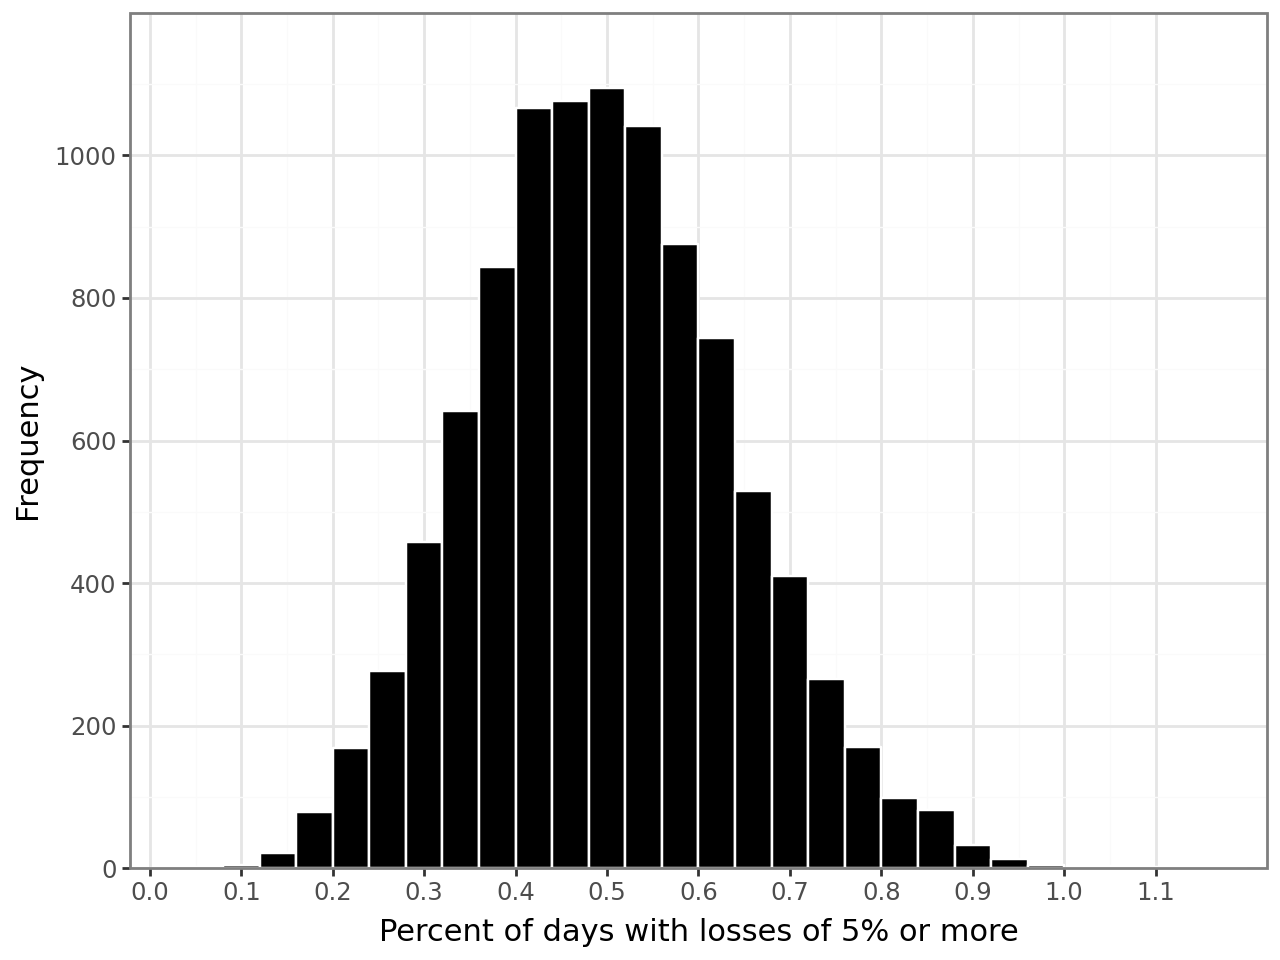

In [43]:
(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill="black", color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=np.arange(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=np.arange(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)


loss1     14.171187
loss2      5.156465
loss3      1.981402
loss4      0.990512
loss5      0.515425
loss6      0.317002
loss7      0.158308
loss8      0.118912
loss9      0.039686
loss10     0.000000
dtype: float64

In [44]:
bootstrap_loss_results.std()

loss1     0.681551
loss2     0.437632
loss3     0.275395
loss4     0.196593
loss5     0.141898
loss6     0.111721
loss7     0.078314
loss8     0.067927
loss9     0.039307
loss10    0.000000
dtype: float64

In [48]:
bootstrap_loss_results.std().std()# Standard Error of bootstrap estimates
se_bootstrap = bootstrap_loss_results["loss5"].std()
print(f"Standard Error: {se_bootstrap:.6f}")


Standard Error: 0.141898


In [51]:
# Calculate 95% confidence interval using SE*2 (approximation)
mean_loss5 = bootstrap_loss_results["loss5"].mean()
ci_lower_se = mean_loss5 - 2 * se_bootstrap
ci_upper_se = mean_loss5 + 2 * se_bootstrap

print(f"Approximate 95% CI using SE*2: [{ci_lower_se:.4f}, {ci_upper_se:.4f}]")

Approximate 95% CI using SE*2: [0.2316, 0.7992]


In [52]:
# Assuming bootstrap_loss_results["loss5"] is a Series of bootstrap results
ci_lower = bootstrap_loss_results["loss5"].quantile(0.025)
ci_upper = bootstrap_loss_results["loss5"].quantile(0.975)

print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")


95% Confidence Interval: [0.2383, 0.7943]


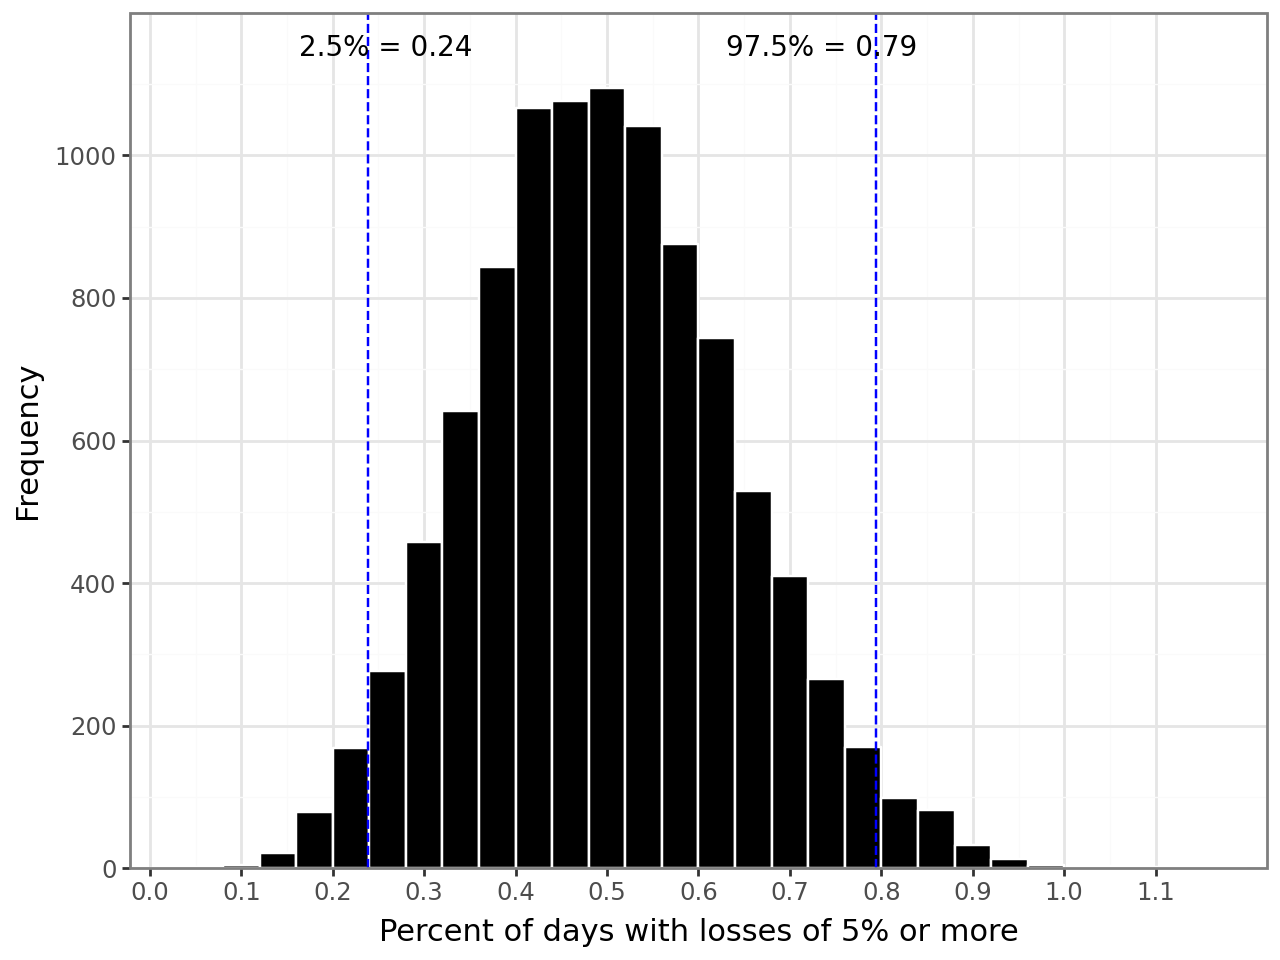

In [47]:
from plotnine import geom_vline, annotate

ci_lower = bootstrap_loss_results["loss5"].quantile(0.025)
ci_upper = bootstrap_loss_results["loss5"].quantile(0.975)

(
    ggplot(bootstrap_loss_results, aes("loss5"))
    + geom_histogram(
        fill="black", color="white", binwidth=0.04, boundary=0, closed="left"
    )
    + geom_vline(xintercept=ci_lower, color="blue", linetype="dashed")
    + geom_vline(xintercept=ci_upper, color="blue", linetype="dashed")
    + annotate("text", x=ci_lower + 0.02, y=1150, label=f"2.5% = {ci_lower:.2f}", size=10)
    + annotate("text", x=ci_upper - 0.06, y=1150, label=f"97.5% = {ci_upper:.2f}", size=10)
    + scale_y_continuous(expand=(0, 0), limits=(0, 1200), breaks=np.arange(0, 1200, 200))
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 1.2), breaks=np.arange(0, 1.2, 0.1))
    + labs(x="Percent of days with losses of 5% or more", y="Frequency")
    + theme_bw()
)
